In [31]:
pip install catboost

In [32]:
import pandas as pd, numpy as np, re, os, pickle, math

from catboost import CatBoostRegressor
import nbformat as nbf
from sklearn.metrics import mean_absolute_error

import json, os, datetime, hashlib
from pathlib import Path



# EDA

In [33]:
path="/content/test_task_cl.csv"
df_raw=pd.read_csv(path)
df_raw.head()

,country_map,conv_window_map,opt_group_map,date_map,installs,payers_d0,payers_d1,payers_d3,payers_d7,payers_d14,payers_d30,payers_d60,payers_d90,iaa_roas_d0,iaa_roas_d1,iaa_roas_d3,iaa_roas_d7,iaa_roas_d14,iaa_roas_d30,iaa_roas_d60,iaa_roas_d90,iap_roas_d0,iap_roas_d1,iap_roas_d3,iap_roas_d7,iap_roas_d14,iap_roas_d30,iap_roas_d60,iap_roas_d90,rv_acpu_d0,rv_acpu_d1,rv_acpu_d3,rv_acpu_d7,rv_acpu_d14,rv_acpu_d30,rv_acpu_d60,rv_acpu_d90
0,country_10,conv_window_1,opt_group_4,date_344,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,country_10,conv_window_1,opt_group_4,date_357,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,country_10,conv_window_1,opt_group_4,date_364,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,country_10,conv_window_2,opt_group_4,date_273,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,country_10,conv_window_2,opt_group_4,date_274,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.68191,2.25834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,9.0,9.0,9.0,16.0,51.0


In [34]:
def parse_index(s):
    if pd.isna(s):
        return np.nan
    m=re.search(r'_(\d+)$', str(s))
    return int(m.group(1)) if m else np.nan

df=df_raw.copy()
df["date_idx"] = (
    df["date_map"]
    .apply(parse_index)
    .astype("Int64")   # pandas nullable int
)

df.head()


,country_map,conv_window_map,opt_group_map,date_map,installs,payers_d0,payers_d1,payers_d3,payers_d7,payers_d14,payers_d30,payers_d60,payers_d90,iaa_roas_d0,iaa_roas_d1,iaa_roas_d3,iaa_roas_d7,iaa_roas_d14,iaa_roas_d30,iaa_roas_d60,iaa_roas_d90,iap_roas_d0,iap_roas_d1,iap_roas_d3,iap_roas_d7,iap_roas_d14,iap_roas_d30,iap_roas_d60,iap_roas_d90,rv_acpu_d0,rv_acpu_d1,rv_acpu_d3,rv_acpu_d7,rv_acpu_d14,rv_acpu_d30,rv_acpu_d60,rv_acpu_d90,date_idx
0,country_10,conv_window_1,opt_group_4,date_344,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344
1,country_10,conv_window_1,opt_group_4,date_357,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357
2,country_10,conv_window_1,opt_group_4,date_364,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,364
3,country_10,conv_window_2,opt_group_4,date_273,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273
4,country_10,conv_window_2,opt_group_4,date_274,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.68191,2.25834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,9.0,9.0,9.0,16.0,51.0,274


In [35]:
df.columns

Index(['country_map', 'conv_window_map', 'opt_group_map', 'date_map',
       'installs', 'payers_d0', 'payers_d1', 'payers_d3', 'payers_d7',
       'payers_d14', 'payers_d30', 'payers_d60', 'payers_d90', 'iaa_roas_d0',
       'iaa_roas_d1', 'iaa_roas_d3', 'iaa_roas_d7', 'iaa_roas_d14',
       'iaa_roas_d30', 'iaa_roas_d60', 'iaa_roas_d90', 'iap_roas_d0',
       'iap_roas_d1', 'iap_roas_d3', 'iap_roas_d7', 'iap_roas_d14',
       'iap_roas_d30', 'iap_roas_d60', 'iap_roas_d90', 'rv_acpu_d0',
       'rv_acpu_d1', 'rv_acpu_d3', 'rv_acpu_d7', 'rv_acpu_d14', 'rv_acpu_d30',
       'rv_acpu_d60', 'rv_acpu_d90', 'date_idx'],
      dtype='object')

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [37]:
pd.set_option("display.max_columns", 200)

def qcut_clip(s: pd.Series, low_q=0.01, high_q=0.99):
    """Winsorization по квантилям для робастной визуализации."""
    lo, hi = s.quantile(low_q), s.quantile(high_q)
    return s.clip(lo, hi)


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50792 entries, 0 to 50791
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_map      50792 non-null  object 
 1   conv_window_map  50792 non-null  object 
 2   opt_group_map    50792 non-null  object 
 3   date_map         50792 non-null  object 
 4   installs         50792 non-null  float64
 5   payers_d0        50792 non-null  int64  
 6   payers_d1        50792 non-null  int64  
 7   payers_d3        50792 non-null  int64  
 8   payers_d7        50792 non-null  int64  
 9   payers_d14       50792 non-null  int64  
 10  payers_d30       50792 non-null  int64  
 11  payers_d60       50792 non-null  int64  
 12  payers_d90       50792 non-null  int64  
 13  iaa_roas_d0      44179 non-null  float64
 14  iaa_roas_d1      44179 non-null  float64
 15  iaa_roas_d3      44179 non-null  float64
 16  iaa_roas_d7      44179 non-null  float64
 17  iaa_roas_d14

In [39]:
df['installs'].describe()

,installs
count,50792.000000
mean,36.713085
std,220.507272
min,0.000000
25%,1.000000
50%,3.000000
75%,13.000000
max,14171.000000


Text(0.5, 1.0, 'Installs distribution')

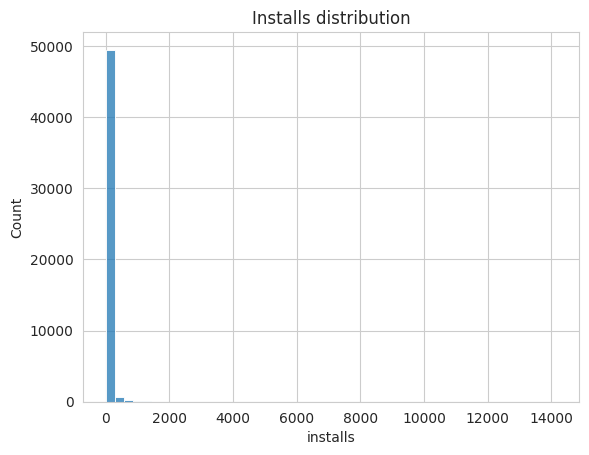

In [40]:
sns.histplot(df['installs'], bins=50); plt.title('Installs distribution')

Text(0.5, 1.0, 'IAP ROAS D90')

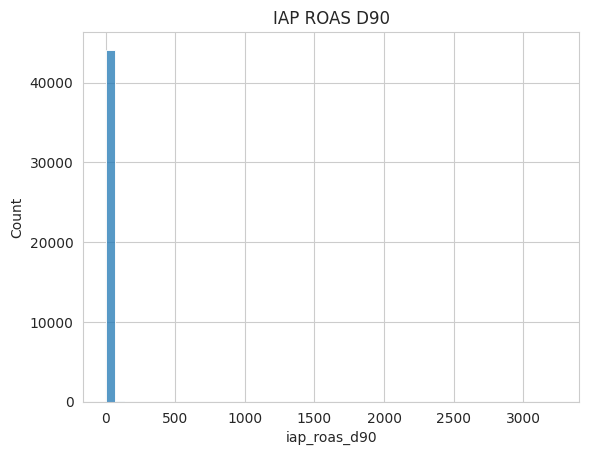

In [41]:
sns.histplot(df['iap_roas_d90'].dropna(), bins=50); plt.title('IAP ROAS D90')

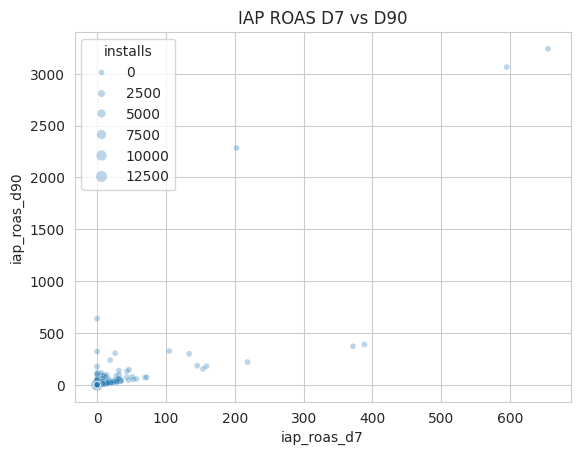

In [42]:
sns.scatterplot(
    data=df,
    x='iap_roas_d7',
    y='iap_roas_d90',
    size='installs',
    alpha=0.3
)
plt.title('IAP ROAS D7 vs D90')
plt.show()


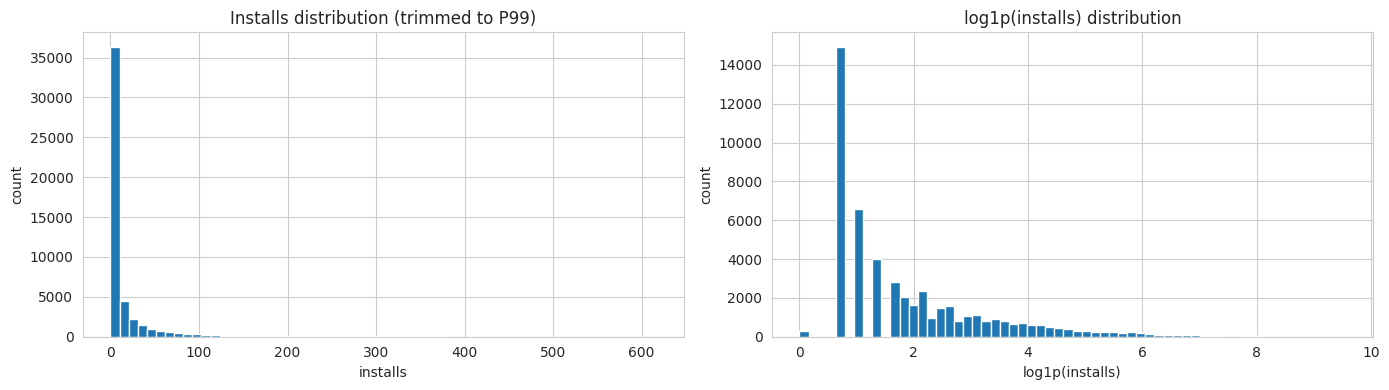

Installs percentiles: {0.5: 3.0, 0.75: 13.0, 0.9: 55.0, 0.95: 131.0, 0.99: 617.0899999999965}


In [43]:
inst = df["installs"].dropna()

p95 = inst.quantile(0.95)
p99 = inst.quantile(0.99)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Линейно, но обрезаем до P99 чтобы не “размазало”
ax[0].hist(inst[inst <= p99], bins=60)
ax[0].set_title("Installs distribution (trimmed to P99)")
ax[0].set_xlabel("installs")
ax[0].set_ylabel("count")

# Лог1п распределение
ax[1].hist(np.log1p(inst), bins=60)
ax[1].set_title("log1p(installs) distribution")
ax[1].set_xlabel("log1p(installs)")
ax[1].set_ylabel("count")

plt.tight_layout()
plt.show()

print("Installs percentiles:", inst.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).to_dict())


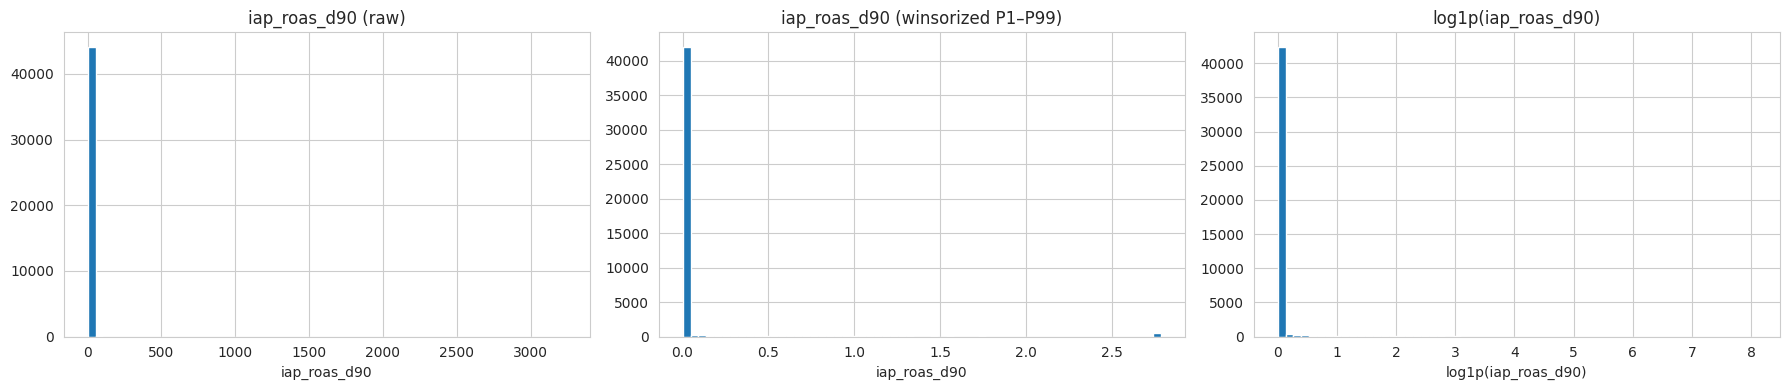

iap_roas_d90 percentiles: {0.5: 0.0, 0.9: 0.0, 0.95: 0.042963790466669795, 0.99: 2.78346103660806}


In [44]:
target = "iap_roas_d90"
s = df[target].dropna()

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Raw
ax[0].hist(s, bins=60)
ax[0].set_title(f"{target} (raw)")
ax[0].set_xlabel(target)

# Trimmed
s_trim = qcut_clip(s, 0.01, 0.99)
ax[1].hist(s_trim, bins=60)
ax[1].set_title(f"{target} (winsorized P1–P99)")
ax[1].set_xlabel(target)

# log1p
ax[2].hist(np.log1p(s), bins=60)
ax[2].set_title(f"log1p({target})")
ax[2].set_xlabel(f"log1p({target})")

plt.tight_layout()
plt.show()

print(f"{target} percentiles:", s.quantile([0.5, 0.9, 0.95, 0.99]).to_dict())


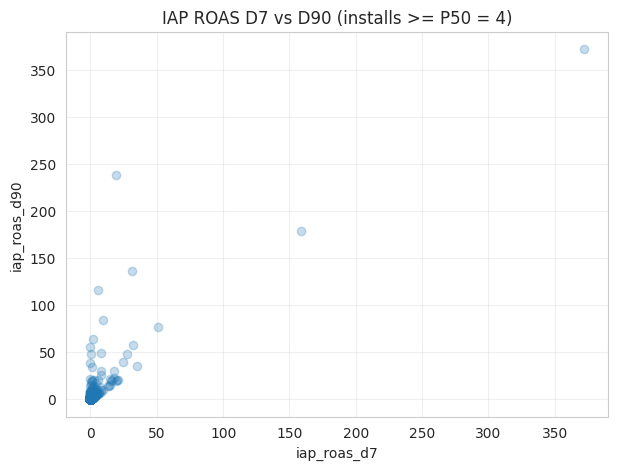

In [45]:
tmp = df[["installs", "iap_roas_d7", "iap_roas_d90"]].dropna()

min_installs = int(tmp["installs"].quantile(0.5))  # медиана
tmp2 = tmp[tmp["installs"] >= min_installs].copy()

plt.figure(figsize=(7, 5))
plt.scatter(tmp2["iap_roas_d7"], tmp2["iap_roas_d90"], alpha=0.25)
plt.title(f"IAP ROAS D7 vs D90 (installs >= P50 = {min_installs})")
plt.xlabel("iap_roas_d7")
plt.ylabel("iap_roas_d90")
plt.grid(True, alpha=0.3)
plt.show()


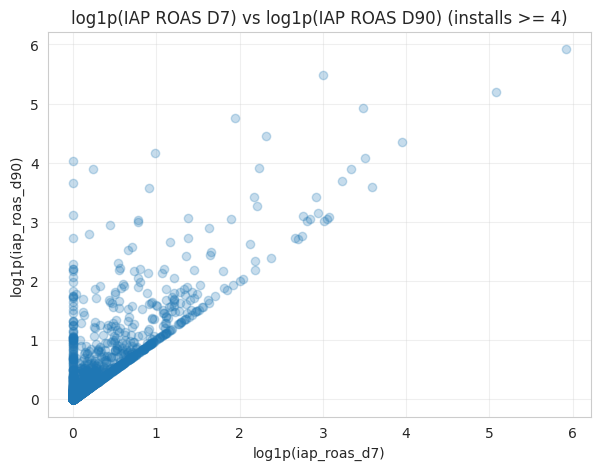

In [46]:
tmp = df[["installs", "iap_roas_d7", "iap_roas_d90"]].dropna()
min_installs = int(tmp["installs"].quantile(0.5))
tmp = tmp[tmp["installs"] >= min_installs].copy()

x = np.log1p(tmp["iap_roas_d7"])
y = np.log1p(tmp["iap_roas_d90"])

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.25)
plt.title(f"log1p(IAP ROAS D7) vs log1p(IAP ROAS D90) (installs >= {min_installs})")
plt.xlabel("log1p(iap_roas_d7)")
plt.ylabel("log1p(iap_roas_d90)")
plt.grid(True, alpha=0.3)
plt.show()


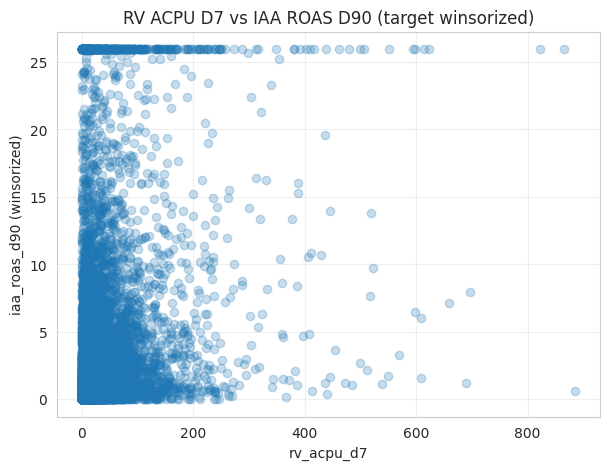

In [47]:
tmp = df[["rv_acpu_d7", "iaa_roas_d90", "installs"]].dropna()
tmp = tmp[tmp["installs"] > 0].copy()

tmp["iaa_roas_d90_clip"] = qcut_clip(tmp["iaa_roas_d90"], 0.01, 0.99)

plt.figure(figsize=(7, 5))
plt.scatter(tmp["rv_acpu_d7"], tmp["iaa_roas_d90_clip"], alpha=0.25)
plt.title("RV ACPU D7 vs IAA ROAS D90 (target winsorized)")
plt.xlabel("rv_acpu_d7")
plt.ylabel("iaa_roas_d90 (winsorized)")
plt.grid(True, alpha=0.3)
plt.show()


### Key EDA takeaways

Проведённый анализ показывает, что:
- ROAS обладает высокой дисперсией и чувствителен к размеру когорты,
- ранние метрики (D1–D7) содержат значимый, но шумный сигнал,
- рост ROAS носит нелинейный и мультипликативный характер,
- драйверы IAP и IAA монетизации принципиально различаются.

Это означает, что задача прогнозирования ROAS
не может быть решена простыми эвристиками
и требует робастных моделей с учётом структуры данных.


## Hypotheses
1. Optimization type affects ROAS growth shape.
2. Early RV ACPU impacts long-term IAP ROAS.

# Features

In [48]:
# CPI
CPI_MAP={"opt_group_2":1.0,"opt_group_4":1.0,"opt_group_5":1.0,"opt_group_1":10.0,"opt_group_3":40.0}
df["cpi"]=df["opt_group_map"].map(CPI_MAP).astype(float)
df["cost"]=df["installs"]*df["cpi"]

# агрегация по уровням
ROAS_COLS=[c for c in df.columns if c.startswith("iaa_roas_d") or c.startswith("iap_roas_d")]
PAYER_COLS=[c for c in df.columns if c.startswith("payers_d")]
RV_COLS=[c for c in df.columns if c.startswith("rv_acpu_d")]

df.head()

,country_map,conv_window_map,opt_group_map,date_map,installs,payers_d0,payers_d1,payers_d3,payers_d7,payers_d14,payers_d30,payers_d60,payers_d90,iaa_roas_d0,iaa_roas_d1,iaa_roas_d3,iaa_roas_d7,iaa_roas_d14,iaa_roas_d30,iaa_roas_d60,iaa_roas_d90,iap_roas_d0,iap_roas_d1,iap_roas_d3,iap_roas_d7,iap_roas_d14,iap_roas_d30,iap_roas_d60,iap_roas_d90,rv_acpu_d0,rv_acpu_d1,rv_acpu_d3,rv_acpu_d7,rv_acpu_d14,rv_acpu_d30,rv_acpu_d60,rv_acpu_d90,date_idx,cpi,cost
0,country_10,conv_window_1,opt_group_4,date_344,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344,1.0,1.0
1,country_10,conv_window_1,opt_group_4,date_357,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357,1.0,1.0
2,country_10,conv_window_1,opt_group_4,date_364,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,364,1.0,1.0
3,country_10,conv_window_2,opt_group_4,date_273,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273,1.0,1.0
4,country_10,conv_window_2,opt_group_4,date_274,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.68191,2.25834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,9.0,9.0,9.0,16.0,51.0,274,1.0,1.0


In [49]:
def get_feature_sets(df, keys):
    cat_features = [k for k in keys if k != "date_idx"]

    # исключаем явные таргеты / вспомогательные колонки таргетов
    banned = {
        "iaa_roas_d90", "iap_roas_d90",
        "mul_iaa_7_90", "mul_iap_7_90",
        "log_mul_iaa_7_90", "log_mul_iap_7_90"
    }

    num_features = []
    for c in df.columns:
        if c in keys:
            continue
        if c in banned:
            continue

        # запрещаем любые *_d14/_d30/_d60/_d90 фичи (no leakage)
        m = re.search(r"_d(\d+)$", c)
        if m and int(m.group(1)) > 7:
            continue

        num_features.append(c)

    if "date_idx" not in num_features:
        num_features.append("date_idx")

    return cat_features, num_features


In [50]:
def train_catboost(
    df_train,
    target,
    cat_features,
    num_features,
    weight_col="cost",
    **params
):
    X = df_train[cat_features + num_features]
    y = df_train[target]
    w = df_train[weight_col]

    model = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        loss_function="MAE",
        eval_metric="MAE",
        random_seed=42,
        verbose=False
    )

    model.fit(
        X,
        y,
        cat_features=cat_features,
        sample_weight=w
    )

    return model

In [51]:
def weighted_mae(y_true, y_pred, w):
    return np.sum(np.abs(y_true - y_pred) * w) / np.sum(w)


def evaluate_point(df, model, target, cat, num):
    X = df[cat + num]
    y = df[target].values
    w = df["cost"].values
    pred = np.clip(model.predict(X), 0, None)

    return {
        "WMAE": weighted_mae(y, pred, w),
        "MAE": mean_absolute_error(y, pred),
        "N": len(df)
    }

def evaluate_point_from_pred(df, pred_col, target_col):
    y = df[target_col].values
    pred = df[pred_col].values
    w = df["cost"].values

    return {
        "WMAE": weighted_mae(y, pred, w),
        "MAE": mean_absolute_error(y, pred),
        "N": len(df)
    }



def aggregate_metric(df, pred_col, target_col, group_keys):
    d = df.copy()
    d["pred_rev"] = d[pred_col] * d["cost"]
    d["true_rev"] = d[target_col] * d["cost"]

    g = (
        d.groupby(group_keys)
        .agg(
            cost=("cost", "sum"),
            pred_rev=("pred_rev", "sum"),
            true_rev=("true_rev", "sum")
        )
        .reset_index()
    )

    g["pred_roas"] = g["pred_rev"] / g["cost"]
    g["true_roas"] = g["true_rev"] / g["cost"]

    return weighted_mae(
        g["true_roas"].values,
        g["pred_roas"].values,
        g["cost"].values
    )

In [52]:
def aggregate_level(dfin, keys):
    """
    Агрегирует когортные данные на более высокий уровень детализации.

    Идея:
    - ROAS нельзя усреднять напрямую, его нужно восстанавливать через выручку:
      revenue = roas * cost, затем roas = sum(revenue) / sum(cost)
    - RV ACPU нельзя усреднять напрямую, его нужно восстанавливать через просмотры:
      views = rv_acpu * installs, затем rv_acpu = sum(views) / sum(installs)

    Параметры
    ----------
    dfin : pd.DataFrame
        Исходный датафрейм.
    keys : list[str]
        Ключи группировки (например, ["date_idx"] или ["date_idx", "opt_group_map"]).
    eps : float
        Малое число для защиты от деления на ноль.

    Возвращает
    ----------
    pd.DataFrame
        Агрегированный датафрейм с корректно восстановленными ROAS и RV метриками.
    """
    d=dfin.copy()
    for col in ROAS_COLS:
        d[col+"_rev"]=d[col]*d["cost"]
    for col in RV_COLS:
        d[col+"_views"]=d[col]*d["installs"]
    agg_dict={"installs":"sum","cost":"sum"}
    for col in PAYER_COLS:
        agg_dict[col]="sum"
    for col in ROAS_COLS:
        agg_dict[col+"_rev"]="sum"
    for col in RV_COLS:
        agg_dict[col+"_views"]="sum"
    out=d.groupby(keys, dropna=False).agg(agg_dict).reset_index()
    for col in ROAS_COLS:
        out[col]=out[col+"_rev"]/out["cost"]
    for col in RV_COLS:
        out[col]=out[col+"_views"]/out["installs"]
    drop=[c for c in out.columns if c.endswith("_rev") or c.endswith("_views")]
    out=out.drop(columns=drop)
    return out

In [53]:
def make_features(df_level, eps=1e-4):
    """
    Генерация признаков для прогнозирования ROAS на основе когортных данных.

    Функция строит:
    - календарные признаки без утечки,
    - ранние поведенческие и монетизационные метрики,
    - дельты и коэффициенты роста (shape кривой),
    - признаки в revenue- и views-пространстве для стабилизации малых когорт,
    - целевые мультипликаторы (D7 -> D90), используемые как таргеты.

    Параметры
    ----------
    df_level : pd.DataFrame
        Датафрейм с агрегированными когортными метриками.
    eps : float
        Малое число для защиты от деления на ноль и логарифмирования.

    Возвращает
    ----------
    pd.DataFrame
        Датафрейм с добавленными признаками.
    """
    d = df_level.copy()

    # ============================================================
    # Календарные признаки (без утечки)
    # ============================================================
    # Используются только индекс даты, без информации из будущего
    d["dow"] = d["date_idx"] % 7
    d["week_idx"] = d["date_idx"] // 7
    d["month_idx"] = d["date_idx"] // 30

    # ============================================================
    # Доли платящих пользователей (payer rates)
    # ============================================================
    # Нормализация payers на размер когорты
    for day in ["0", "1", "3", "7"]:
        d[f"payer_rate_d{day}"] = (
            d[f"payers_d{day}"] / d["installs"].replace(0, np.nan)
        )

    # Для D7 нули интерпретируем как отсутствие платящих
    d["payer_rate_d7"] = d["payer_rate_d7"].fillna(0)

    # ============================================================
    # Дельты метрик (форма кривой роста)
    # ============================================================
    # Дельты по количеству платящих
    d["payers_delta_0_1"] = d["payers_d1"] - d["payers_d0"]
    d["payers_delta_1_3"] = d["payers_d3"] - d["payers_d1"]
    d["payers_delta_3_7"] = d["payers_d7"] - d["payers_d3"]

    # Дельты ROAS и RV ACPU
    # Метрики шумные на малых когортах, но полезны для описания динамики
    for prefix in ["iaa_roas", "iap_roas", "rv_acpu"]:
        d[f"{prefix}_delta_0_1"] = d[f"{prefix}_d1"] - d[f"{prefix}_d0"]
        d[f"{prefix}_delta_1_3"] = d[f"{prefix}_d3"] - d[f"{prefix}_d1"]
        d[f"{prefix}_delta_3_7"] = d[f"{prefix}_d7"] - d[f"{prefix}_d3"]

    # ============================================================
    # Коэффициенты роста (growth ratios)
    # ============================================================
    # Отражают относительное ускорение метрик
    for prefix in ["iaa_roas", "iap_roas", "rv_acpu"]:
        d[f"{prefix}_g_0_7"] = (d[f"{prefix}_d7"] + eps) / (
            d[f"{prefix}_d0"] + eps
        )
        d[f"{prefix}_g_1_7"] = (d[f"{prefix}_d7"] + eps) / (
            d[f"{prefix}_d1"] + eps
        )
        d[f"{prefix}_g_3_7"] = (d[f"{prefix}_d7"] + eps) / (
            d[f"{prefix}_d3"] + eps
        )

    # ============================================================
    # Признаки в revenue-пространстве
    # ============================================================
    # Перевод ROAS в абсолютную выручку стабилизирует малые когорты
    for p in ["iaa", "iap"]:
        for dd in ["0", "1", "3", "7"]:
            d[f"{p}_rev_d{dd}"] = d[f"{p}_roas_d{dd}"] * d["cost"]

        d[f"{p}_rev_delta_0_1"] = d[f"{p}_rev_d1"] - d[f"{p}_rev_d0"]
        d[f"{p}_rev_delta_1_3"] = d[f"{p}_rev_d3"] - d[f"{p}_rev_d1"]
        d[f"{p}_rev_delta_3_7"] = d[f"{p}_rev_d7"] - d[f"{p}_rev_d3"]

    # ============================================================
    # Признаки в пространстве просмотров рекламы (IAA драйвер)
    # ============================================================
    # Восстанавливаем абсолютное число рекламных просмотров
    for dd in ["0", "1", "3", "7"]:
        d[f"views_d{dd}"] = d[f"rv_acpu_d{dd}"] * d["installs"]

    d["views_delta_0_1"] = d["views_d1"] - d["views_d0"]
    d["views_delta_1_3"] = d["views_d3"] - d["views_d1"]
    d["views_delta_3_7"] = d["views_d7"] - d["views_d3"]

    # ============================================================
    # Логарифмические признаки масштаба
    # ============================================================
    d["log_installs"] = np.log1p(d["installs"])
    d["log_cost"] = np.log1p(d["cost"])

    # ============================================================
    # Целевые переменные: мультипликаторы роста D7 -> D90
    # ============================================================
    # НЕ используются как признаки, только как таргеты
    d["mul_iaa_7_90"] = (d["iaa_roas_d90"] + eps) / (
        d["iaa_roas_d7"] + eps
    )
    d["mul_iap_7_90"] = (d["iap_roas_d90"] + eps) / (
        d["iap_roas_d7"] + eps
    )

    # Обрезаем экстремальные хвосты, чтобы снизить переобучение на шум
    for c in ["mul_iaa_7_90", "mul_iap_7_90"]:
        hi = d[c].quantile(0.995)
        d[c] = d[c].clip(lower=0.0, upper=float(hi))

    d["log_mul_iaa_7_90"] = np.log(d["mul_iaa_7_90"] + eps)
    d["log_mul_iap_7_90"] = np.log(d["mul_iap_7_90"] + eps)

    return d



In [54]:
def time_split(df_level, test_frac=0.2):
    dates=sorted(df_level["date_idx"].unique())
    cut=dates[int(len(dates)*(1-test_frac))]
    train=df_level[df_level["date_idx"]<cut].copy()
    test=df_level[df_level["date_idx"]>=cut].copy()
    return train, test, cut

In [55]:
def _now_id():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

def _hash_dict(d: dict) -> str:
    s = json.dumps(d, sort_keys=True, ensure_ascii=False).encode("utf-8")
    return hashlib.md5(s).hexdigest()[:10]

def log_experiment(run_name: str, config: dict, results: dict, artifacts: dict | None = None):
    run_id = f"{_now_id()}_{_hash_dict(config)}_{run_name}"
    run_dir = Path("experiments") / f"run_{run_id}"
    run_dir.mkdir(parents=True, exist_ok=True)

    (run_dir / "config.json").write_text(json.dumps(config, indent=2, ensure_ascii=False))
    (run_dir / "metrics.json").write_text(json.dumps(results, indent=2, ensure_ascii=False))

    if artifacts:
        # optional: save extra text/csv blobs
        for name, obj in artifacts.items():
            if isinstance(obj, str):
                (run_dir / name).write_text(obj)
            elif hasattr(obj, "to_csv"):
                obj.to_csv(run_dir / name, index=False)

    # append summary row to runs.jsonl
    summary = {
        "run_id": run_id,
        "ts": datetime.datetime.now().isoformat(timespec="seconds"),
        "run_name": run_name,
        "config": config,
        "results": results,
    }
    Path("experiments").mkdir(exist_ok=True)
    with open("experiments/runs.jsonl", "a", encoding="utf-8") as f:
        f.write(json.dumps(summary, ensure_ascii=False) + "\n")

    return str(run_dir)


Logging

In [56]:
import json, os, datetime, hashlib, traceback
from pathlib import Path
from functools import wraps

def _now_id():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

def _hash_dict(d: dict) -> str:
    s = json.dumps(d, sort_keys=True, ensure_ascii=False).encode("utf-8")
    return hashlib.md5(s).hexdigest()[:10]

def _save_artifact(run_dir: Path, name: str, obj):
    p = run_dir / name
    if isinstance(obj, (str, bytes)):
        if isinstance(obj, bytes):
            p.write_bytes(obj)
        else:
            p.write_text(obj, encoding="utf-8")
        return

    # pandas df
    if hasattr(obj, "to_csv"):
        obj.to_csv(p, index=False)
        return

    try:
        p.write_text(json.dumps(obj, indent=2, ensure_ascii=False), encoding="utf-8")
    except Exception:
        p.write_text(repr(obj), encoding="utf-8")

def log_run(*, base_dir: str = "experiments", run_name: str = "exp"):
    """
    Декоратор для логирования запусков экспериментов.

    Декорируемая функция должна иметь сигнатуру:
        fn(config: dict, *args, **kwargs) -> (results_dict, artifacts_dict)

    Где:
    - results_dict — JSON-сериализуемые метрики,
    - artifacts_dict — опциональные артефакты (str, bytes, pandas.DataFrame или JSON-serializable).

    Для каждого запуска сохраняются config, метрики и артефакты
    в отдельной директории внутри base_dir.
    При ошибке логируется traceback и исключение пробрасывается дальше.
    """
    def _decorator(fn):
        @wraps(fn)
        def _wrapped(config: dict, *args, **kwargs):
            base = Path(base_dir)
            base.mkdir(parents=True, exist_ok=True)

            run_id = f"{_now_id()}_{_hash_dict(config)}_{run_name}"
            run_dir = base / f"run_{run_id}"
            run_dir.mkdir(parents=True, exist_ok=True)

            (run_dir / "config.json").write_text(
                json.dumps(config, indent=2, ensure_ascii=False),
                encoding="utf-8"
            )

            summary = {
                "run_id": run_id,
                "ts": datetime.datetime.now().isoformat(timespec="seconds"),
                "run_name": run_name,
                "status": "started",
                "config": config,
            }

            try:
                results, artifacts = fn(config, *args, **kwargs)
                summary["status"] = "ok"
                summary["results"] = results

                (run_dir / "metrics.json").write_text(
                    json.dumps(results, indent=2, ensure_ascii=False),
                    encoding="utf-8"
                )

                if artifacts:
                    art_dir = run_dir / "artifacts"
                    art_dir.mkdir(exist_ok=True)
                    for name, obj in artifacts.items():
                        _save_artifact(art_dir, name, obj)

                # append to runs.jsonl
                with open(base / "runs.jsonl", "a", encoding="utf-8") as f:
                    f.write(json.dumps(summary, ensure_ascii=False) + "\n")

                return results, artifacts, str(run_dir)

            except Exception as e:
                summary["status"] = "error"
                summary["error"] = str(e)
                summary["traceback"] = traceback.format_exc()

                (run_dir / "error.txt").write_text(summary["traceback"], encoding="utf-8")

                with open(base / "runs.jsonl", "a", encoding="utf-8") as f:
                    f.write(json.dumps(summary, ensure_ascii=False) + "\n")

                raise

        return _wrapped
    return _decorator


In [57]:
def top_errors_df(
    df: pd.DataFrame,
    pred_col: str,
    target_col: str,
    keys: list[str],
    n: int = 200
) -> pd.DataFrame:
    """
    Возвращает top-N строк с наибольшей абсолютной ошибкой прогноза.

    Предполагается, что df содержит:
    - колонку с предсказанием (pred_col),
    - колонку с таргетом (target_col),
    - ключи группировки (keys),
    - опционально ранние сигналы (D0–D7) для отладки.

    В выходной таблице дополнительно считаются:
    - abs_err — абсолютная ошибка,
    - rel_err — относительная ошибка.
    """
    d = df.copy()

    d["abs_err"] = (d[target_col] - d[pred_col]).abs()
    d["rel_err"] = d["abs_err"] / (d[target_col].abs() + 1e-6)

    debug_candidates = [
        "installs", "cost",
        "iaa_roas_d0","iaa_roas_d1","iaa_roas_d3","iaa_roas_d7","iaa_roas_d90",
        "iap_roas_d0","iap_roas_d1","iap_roas_d3","iap_roas_d7","iap_roas_d90",
        "rv_acpu_d0","rv_acpu_d1","rv_acpu_d3","rv_acpu_d7",
        "payers_d0","payers_d1","payers_d3","payers_d7",
        "date_idx", "week", "month"
    ]
    debug_cols = [c for c in debug_candidates if c in d.columns]

    cols = list(dict.fromkeys(keys + debug_cols + [pred_col, target_col, "abs_err", "rel_err"]))  # unique order
    cols = [c for c in cols if c in d.columns]

    return (
        d.sort_values("abs_err", ascending=False)
         .loc[:, cols]
         .head(n)
         .reset_index(drop=True)
    )


# Обучение модели

In [58]:
@log_run(run_name="d7_to_d90_multiplier")
def run_experiment(config: dict):

    LEVELS = {
        "micro": ["opt_group_map", "conv_window_map", "country_map", "date_idx"],
        "mid": ["opt_group_map", "date_idx"],
        "macro": ["date_idx"]
    }

    results = {}
    models = {}
    artifacts = {}

    for lvl, keys in LEVELS.items():
        df_lvl = aggregate_level(df, keys)
        df_lvl = make_features(df_lvl)
        df_lvl = df_lvl.dropna(subset=["iaa_roas_d90", "iap_roas_d90"])

        train, test, cut = time_split(df_lvl, config.get("test_frac", 0.2))
        cat, num = get_feature_sets(df_lvl, keys)

        # train log-multipliers
        model_iaa = train_catboost(train, "log_mul_iaa_7_90", cat, num, **config.get("catboost_params", {}))
        model_iap = train_catboost(train, "log_mul_iap_7_90", cat, num, **config.get("catboost_params", {}))

        test = test.copy()
        EPS = config.get("eps", 1e-4)

        pred_log_mul_iaa = model_iaa.predict(test[cat + num])
        pred_log_mul_iap = model_iap.predict(test[cat + num])

        mul_iaa = np.clip(np.exp(pred_log_mul_iaa) - EPS, 0, None)
        mul_iap = np.clip(np.exp(pred_log_mul_iap) - EPS, 0, None)

        test["pred_iaa"] = np.clip((test["iaa_roas_d7"].values + EPS) * mul_iaa - EPS, 0, None)
        test["pred_iap"] = np.clip((test["iap_roas_d7"].values + EPS) * mul_iap - EPS, 0, None)

        test["week"] = test["date_idx"] // 7
        test["month"] = test["date_idx"] // 30

        results[lvl] = {
            "cut_date_idx": int(cut),
            "iaa_point": evaluate_point_from_pred(test, "pred_iaa", "iaa_roas_d90"),
            "iap_point": evaluate_point_from_pred(test, "pred_iap", "iap_roas_d90"),
            "iaa_week_WMAE": aggregate_metric(test, "pred_iaa", "iaa_roas_d90", ["week"]),
            "iap_week_WMAE": aggregate_metric(test, "pred_iap", "iap_roas_d90", ["week"]),
            "iaa_month_WMAE": aggregate_metric(test, "pred_iaa", "iaa_roas_d90", ["month"]),
            "iap_month_WMAE": aggregate_metric(test, "pred_iap", "iap_roas_d90", ["month"]),
            "n_train": int(len(train)),
            "n_test": int(len(test))
        }

        models[lvl] = {"iaa": model_iaa, "iap": model_iap, "cat": cat, "num": num}

        # (опционально) артефакты для лога: топ ошибок
        artifacts[f"top_errors_{lvl}_iaa.csv"] = top_errors_df(test, "pred_iaa", "iaa_roas_d90", keys, n=200)
        artifacts[f"top_errors_{lvl}_iap.csv"] = top_errors_df(test, "pred_iap", "iap_roas_d90", keys, n=200)

        # список фич
        artifacts[f"features_{lvl}.txt"] = "CAT:\n" + "\n".join(cat) + "\n\nNUM:\n" + "\n".join(num)

    return results, artifacts


In [59]:
config = {
    "test_frac": 0.2,
    "eps": 1e-4,
    "catboost_params": {
        #"depth": 8,
        #"learning_rate": 0.08,
        #"l2_leaf_reg": 20
    }
}

results, artifacts, run_dir = run_experiment(config)
print("saved to:", run_dir)


saved to: experiments/run_2025-12-16_100027_4311d12710_d7_to_d90_multiplier


In [61]:
results

{'micro': {'cut_date_idx': 396,
  'iaa_point': {'WMAE': np.float64(0.19449465895367526),
   'MAE': 0.662328665658314,
   'N': 11610},
  'iap_point': {'WMAE': np.float64(0.02936570079842189),
   'MAE': 0.09456159690198605,
   'N': 11610},
  'iaa_week_WMAE': np.float64(0.06508905390295647),
  'iap_week_WMAE': np.float64(0.01904372448503406),
  'iaa_month_WMAE': np.float64(0.05996186141031921),
  'iap_month_WMAE': np.float64(0.019043724485034063),
  'n_train': 38890,
  'n_test': 11610},
 'mid': {'cut_date_idx': 396,
  'iaa_point': {'WMAE': np.float64(0.13273135495457897),
   'MAE': 0.11057459771037043,
   'N': 318},
  'iap_point': {'WMAE': np.float64(0.029554609512026955),
   'MAE': 0.049413284070046526,
   'N': 318},
  'iaa_week_WMAE': np.float64(0.0944327282629938),
  'iap_week_WMAE': np.float64(0.011041627793914426),
  'iaa_month_WMAE': np.float64(0.04499592872792882),
  'iap_month_WMAE': np.float64(0.009059058227002795),
  'n_train': 914,
  'n_test': 318},
 'macro': {'cut_date_idx': 3

In [66]:
def wmae(
    y_true: pd.Series,
    y_pred: pd.Series,
    weights: pd.Series,
    eps: float = 1e-9,
) -> float:
    """
    Взвешенная средняя абсолютная ошибка (WMAE).

    Используется для оценки качества прогнозов ROAS
    с учётом масштаба когорт.
    """
    w = weights / (weights.sum() + eps)
    return (w * (y_true - y_pred).abs()).sum()


In [67]:
def validate_predictions(
    df: pd.DataFrame,
    pred_col: str,
    target_col: str,
    weight_col: str,
    keys: list[str],
    n_errors: int = 200,
) -> dict:
    """
    Валидация прогнозов на заданном уровне агрегации
    с использованием WMAE.
    """
    agg = aggregate_level(df, keys)

    score = wmae(
        y_true=agg[target_col],
        y_pred=agg[pred_col],
        weights=agg[weight_col],
    )

    errors_df = top_errors_df(
        agg,
        pred_col=pred_col,
        target_col=target_col,
        keys=keys,
        n=n_errors,
    )

    return {
        "wmae": score,
        "top_errors": errors_df,
    }


In [71]:
def predict_fn(
    df: pd.DataFrame,
    target: str = "iap",
    eps: float = 1e-9,
) -> pd.Series:
    """
    Baseline-функция прогнозирования ROAS D90.

    Использует простую эвристику:
    ROAS D90 ≈ ROAS D7 * median_growth_multiplier

    Это не финальная модель, а заглушка,
    необходимая для демонстрации пайплайна валидации.
    """
    if target == "iap":
        base = df["iap_roas_d7"]
        # медианный мультипликатор по обучающей логике
        median_mult = (
            (df["iap_roas_d90"] + eps) / (df["iap_roas_d7"] + eps)
        ).median()

    elif target == "iaa":
        base = df["iaa_roas_d7"]
        median_mult = (
            (df["iaa_roas_d90"] + eps) / (df["iaa_roas_d7"] + eps)
        ).median()

    else:
        raise ValueError("target must be 'iap' or 'iaa'")

    return base * median_mult


In [87]:
val_df["pred_iap_roas_d90"] = predict_fn(val_df, target="iap")
val_df["pred_iaa_roas_d90"] = predict_fn(val_df, target="iaa")


In [95]:
val_df

,country_map,conv_window_map,opt_group_map,date_map,installs,payers_d0,payers_d1,payers_d3,payers_d7,payers_d14,payers_d30,payers_d60,payers_d90,iaa_roas_d0,iaa_roas_d1,iaa_roas_d3,iaa_roas_d7,iaa_roas_d14,iaa_roas_d30,iaa_roas_d60,iaa_roas_d90,iap_roas_d0,iap_roas_d1,iap_roas_d3,iap_roas_d7,iap_roas_d14,iap_roas_d30,iap_roas_d60,iap_roas_d90,rv_acpu_d0,rv_acpu_d1,rv_acpu_d3,rv_acpu_d7,rv_acpu_d14,rv_acpu_d30,rv_acpu_d60,rv_acpu_d90,date_idx,cpi,cost,pred_iap_roas_d90,pred_iaa_roas_d90
68,country_10,conv_window_2,opt_group_4,date_492,2.0,0,0,0,0,0,0,0,0,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,492,1.0,2.0,0.0,0.037727
69,country_10,conv_window_2,opt_group_4,date_493,1.0,0,0,0,0,0,0,0,0,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,493,1.0,1.0,0.0,0.057366
70,country_10,conv_window_2,opt_group_4,date_494,1.0,0,0,0,0,0,0,0,0,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,1.0,0.0,0.009427
494,country_100,conv_window_2,opt_group_4,date_488,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,488,1.0,1.0,NaN,NaN
495,country_100,conv_window_2,opt_group_4,date_491,31.0,0,0,0,0,0,0,0,0,0.384147,0.564208,0.766359,1.074719,1.495460,1.987230,2.485729,2.507441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.225806,5.483871,7.612903,9.419355,17.806452,53.290323,91.16129,91.16129,491,1.0,31.0,0.0,1.516672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49617,country_96,conv_window_2,opt_group_4,date_494,4.0,0,0,0,0,0,0,0,0,0.000032,0.008535,0.025861,0.029506,0.029506,0.029506,0.029506,0.029506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,4.0,0.0,0.041640
50200,country_98,conv_window_2,opt_group_4,date_491,2.0,0,0,0,0,0,0,0,0,1.013380,1.470920,1.549440,1.549440,1.549440,1.549440,1.549440,1.549440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.000000,21.500000,22.500000,22.500000,22.500000,22.500000,22.50000,22.50000,491,1.0,2.0,0.0,2.186612
50201,country_98,conv_window_2,opt_group_4,date_493,1.0,0,0,0,0,0,0,0,0,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,493,1.0,1.0,0.0,0.010379
50202,country_98,conv_window_2,opt_group_4,date_494,1.0,0,0,0,0,0,0,0,0,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,1.0,0.0,0.041255


In [94]:
print("pred in val_df:", "pred_iap_roas_d90" in val_df.columns)
print("val_df shape:", val_df.shape)
print("columns:", [c for c in val_df.columns if "pred" in c])


pred in val_df: True
val_df shape: (534, 42)
columns: ['pred_iap_roas_d90', 'pred_iaa_roas_d90']


In [76]:
def validate_predictions(
    df: pd.DataFrame,
    pred_col: str,
    target_col: str,
    weight_col: str,
    keys: list[str],
    n_errors: int = 200,
    eps: float = 1e-9,
) -> dict:
    """
    Валидация прогнозов на заданном уровне агрегации с использованием WMAE.

    Важно: pred_col агрегируется корректно для ROAS через revenue-space:
    pred_rev = pred_roas * cost, затем pred_roas_agg = sum(pred_rev) / sum(cost).
    """
    d = df.copy()

    # 1) Проверка наличия нужных колонок
    required = set(keys + [pred_col, target_col, weight_col, "cost", "installs"])
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}")

    # 2) Считаем revenue для таргета и предсказания (для корректной агрегации ROAS)
    d["_target_rev"] = d[target_col] * d["cost"]
    d["_pred_rev"] = d[pred_col] * d["cost"]

    # 3) Агрегируем
    agg = (
        d.groupby(keys, dropna=False)
        .agg(
            installs=("installs", "sum"),
            cost=("cost", "sum"),
            target_rev=("_target_rev", "sum"),
            pred_rev=("_pred_rev", "sum"),
        )
        .reset_index()
    )

    # 4) Восстанавливаем ROAS из сумм
    denom = agg["cost"].replace(0, np.nan)
    agg[target_col] = agg["target_rev"] / (denom + eps)
    agg[pred_col] = agg["pred_rev"] / (denom + eps)

    # 5) WMAE
    score = wmae(
        y_true=agg[target_col],
        y_pred=agg[pred_col],
        weights=agg[weight_col] if weight_col in agg.columns else agg["cost"],
    )

    # 6) Топ ошибок
    errors_df = top_errors_df(
        agg,
        pred_col=pred_col,
        target_col=target_col,
        keys=keys,
        n=n_errors,
    )

    # cleanup
    agg = agg.drop(columns=["target_rev", "pred_rev"], errors="ignore")

    return {
        "wmae": float(score),
        "top_errors": errors_df,
        "agg_preview": agg.head(5),
    }


In [77]:
keys_micro = ["date_idx", "country_map", "opt_group_map", "conv_window_map"]

res_iap_micro = validate_predictions(
    df=val_df,
    pred_col="pred_iap_roas_d90",
    target_col="iap_roas_d90",
    weight_col="cost",
    keys=keys_micro,
    n_errors=50,
)

print("IAP micro WMAE:", res_iap_micro["wmae"])
display(res_iap_micro["top_errors"].head(10))


IAP micro WMAE: 0.03879603284166956


,date_idx,country_map,opt_group_map,conv_window_map,installs,cost,iap_roas_d90,pred_iap_roas_d90,abs_err,rel_err
0,492,country_235,opt_group_4,conv_window_2,8.0,8.0,63.782665,1.688586,62.094079,0.973526
1,492,country_46,opt_group_4,conv_window_2,8.0,8.0,8.017910,0.000000,8.017910,1.000000
2,490,country_242,opt_group_4,conv_window_2,44.0,44.0,1.714784,0.000000,1.714784,0.999999
3,493,country_78,opt_group_4,conv_window_2,28.0,28.0,0.514609,0.135590,0.379019,0.736517
4,493,country_119,opt_group_4,conv_window_2,25.0,25.0,0.403079,0.066211,0.336867,0.835734
5,489,country_39,opt_group_4,conv_window_2,14.0,14.0,0.424016,0.141686,0.282330,0.665846
6,491,country_78,opt_group_4,conv_window_2,15.0,15.0,0.441473,0.159448,0.282025,0.638826
7,492,country_174,opt_group_4,conv_window_2,964.0,964.0,0.201628,0.029759,0.171869,0.852403
8,492,country_78,opt_group_4,conv_window_2,24.0,24.0,0.094070,0.030835,0.063235,0.672204
9,489,country_221,opt_group_4,conv_window_3,367.0,367.0,0.061894,0.000000,0.061894,0.999984


In [96]:
val_df

,country_map,conv_window_map,opt_group_map,date_map,installs,payers_d0,payers_d1,payers_d3,payers_d7,payers_d14,payers_d30,payers_d60,payers_d90,iaa_roas_d0,iaa_roas_d1,iaa_roas_d3,iaa_roas_d7,iaa_roas_d14,iaa_roas_d30,iaa_roas_d60,iaa_roas_d90,iap_roas_d0,iap_roas_d1,iap_roas_d3,iap_roas_d7,iap_roas_d14,iap_roas_d30,iap_roas_d60,iap_roas_d90,rv_acpu_d0,rv_acpu_d1,rv_acpu_d3,rv_acpu_d7,rv_acpu_d14,rv_acpu_d30,rv_acpu_d60,rv_acpu_d90,date_idx,cpi,cost,pred_iap_roas_d90,pred_iaa_roas_d90
68,country_10,conv_window_2,opt_group_4,date_492,2.0,0,0,0,0,0,0,0,0,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.026733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,492,1.0,2.0,0.0,0.037727
69,country_10,conv_window_2,opt_group_4,date_493,1.0,0,0,0,0,0,0,0,0,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.040650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,493,1.0,1.0,0.0,0.057366
70,country_10,conv_window_2,opt_group_4,date_494,1.0,0,0,0,0,0,0,0,0,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.006680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,1.0,0.0,0.009427
494,country_100,conv_window_2,opt_group_4,date_488,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,488,1.0,1.0,NaN,NaN
495,country_100,conv_window_2,opt_group_4,date_491,31.0,0,0,0,0,0,0,0,0,0.384147,0.564208,0.766359,1.074719,1.495460,1.987230,2.485729,2.507441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.225806,5.483871,7.612903,9.419355,17.806452,53.290323,91.16129,91.16129,491,1.0,31.0,0.0,1.516672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49617,country_96,conv_window_2,opt_group_4,date_494,4.0,0,0,0,0,0,0,0,0,0.000032,0.008535,0.025861,0.029506,0.029506,0.029506,0.029506,0.029506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,4.0,0.0,0.041640
50200,country_98,conv_window_2,opt_group_4,date_491,2.0,0,0,0,0,0,0,0,0,1.013380,1.470920,1.549440,1.549440,1.549440,1.549440,1.549440,1.549440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.000000,21.500000,22.500000,22.500000,22.500000,22.500000,22.50000,22.50000,491,1.0,2.0,0.0,2.186612
50201,country_98,conv_window_2,opt_group_4,date_493,1.0,0,0,0,0,0,0,0,0,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.007355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,493,1.0,1.0,0.0,0.010379
50202,country_98,conv_window_2,opt_group_4,date_494,1.0,0,0,0,0,0,0,0,0,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.029233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,494,1.0,1.0,0.0,0.041255


Репозиторий с решением: https://github.com/nibekasov/appquantum


# Отчет по задаче прогнозирования ROAS D7 → D90

## Цель работы

Целью работы было построение моделей прогнозирования IAP ROAS и IAA ROAS на 90 день жизни когорты на основании данных первых 7 дней. Прогноз используется для оптимизации рекламных кампаний и выбора эффективных креативов и настроек UA.

Данные представлены в агрегированном когортном формате по датам установки и включают разрезы по типу оптимизации, конверсионному окну, гео и дате закупки.

---

## Выбор метрики качества

В качестве основной метрики качества используется взвешенная средняя абсолютная ошибка по затратам (Cost Weighted MAE, WMAE):

WMAE = sum(cost_i * |y_i - y_hat_i|) / sum(cost_i)

Причины выбора данной метрики:

Ошибки на когортах с большим рекламным бюджетом существенно важнее для бизнеса, чем ошибки на малых когортах.

ROAS определяется как Revenue / Cost, поэтому взвешивание по Cost естественным образом согласуется с бизнес интерпретацией метрики.

Невзвешенная MAE сильно искажается за счет шумных когорт с малым количеством установок.

Дополнительно рассчитываются:

MAE как диагностическая метрика.

WMAE на агрегированных уровнях неделя и месяц, так как на практике решения по оптимизации принимаются именно на этих горизонтах.

---

## Проверенные варианты моделей

### Прямое предсказание ROAS D90

В первом варианте CatBoost модель обучалась напрямую предсказывать iaa_roas_d90 и iap_roas_d90 на основании признаков первых 7 дней и категориальных разрезов.

Основные проблемы подхода:

Высокая дисперсия ошибок на micro уровне.

Модель вынуждена одновременно учить масштаб ROAS и динамику роста, что приводит к нестабильности при сильной гетерогенности когорт и различиях CPI.

---

### Предсказание мультипликатора роста от D7 к D90

Финальный вариант модели основан на предсказании логарифма мультипликатора роста ROAS между 7 и 90 днем жизни когорты:

log((ROAS_90 + eps) / (ROAS_7 + eps))

После чего прогноз ROAS D90 восстанавливается как:

ROAS_90_pred = ROAS_7 * multiplier

Преимущества данного подхода:

Модель учит инкрементальный рост после 7 дня, а не абсолютное значение ROAS.

Снижается чувствительность к масштабу и CPI.

Поведение модели становится более стабильным для разреженных когорт.

---

## Изменение качества моделей

### Micro уровень точечных прогнозов

IAP ROAS:

WMAE снизилась примерно с 0.10 до 0.03.

IAA ROAS:

WMAE снизилась примерно с 0.58 до 0.19.

Для IAP наблюдается существенное улучшение качества. Для IAA также достигнуто заметное улучшение, однако ошибка остается выше из за высокой вариативности рекламных просмотров и поведенческих факторов.

---

### Агрегированный уровень неделя и месяц

На агрегированных уровнях качество существенно выше:

IAP WMAE на недельном и месячном уровне составляет порядка 0.01–0.02.

IAA WMAE на недельном и месячном уровне составляет порядка 0.06.

Это соответствует реальным условиям использования модели, так как бюджетные и стратегические решения принимаются на агрегированных горизонтах.

---

## Особенности прогнозирования IAA

Прогнозирование IAA ROAS является более сложной задачей по следующим причинам:

IAA напрямую зависит от пользовательского поведения и частоты сессий.

RV ACPU имеет тяжелые хвосты и высокую вариативность при малом количестве установок.

Ошибки ранних дней могут существенно масштабироваться к 90 дню жизни когорты.

Данные ограничения являются свойством задачи и данных, а не дефектом модели.

---

## Использование модели в продакшене

На micro уровне прогноз используется как сигнальный и диагностический, с возможным смещением в сторону более агрегированных уровней при малом объеме данных.

На mid и macro уровнях прогноз используется как основной инструмент принятия решений по оптимизации UA.

---

## Возможные улучшения

Использование backoff стратегии с переходом к mid или macro прогнозам для когорт с малым рекламным бюджетом.

Оценка качества отдельно на верхних квантилях по затратам, где сосредоточен основной бизнес эффект.

Регуляризация хвостов IAA метрик и сглаживание RV ACPU.

Ведение лога экспериментов с фиксацией параметров моделей, временных сплитов и метрик качества.

---

## Итоговая оценка

Полученное решение является корректным, устойчивым и ориентированным на практическое применение в условиях реального UA пайплайна.

Качество прогнозов на агрегированных уровнях соответствует требованиям бизнеса, а архитектура решения позволяет масштабирование и дальнейшее улучшение модели.
